## Skorch backprop network

In [31]:

import subprocess

# Installation on Google Colab
!git clone https://github.com/jlm429/pyperch


fatal: destination path 'pyperch' already exists and is not an empty directory.


In [1]:
import numpy as np
from sklearn.datasets import make_classification
from torch import nn, optim
from skorch import NeuralNetClassifier
from pyperch.pyperch.neural.backprop_nn import BackpropModule
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from skorch.callbacks import EpochScoring,EarlyStopping
from skorch.callbacks import Callback
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, make_scorer
import torch



In [2]:
X1 = pd.read_csv('bankmarketing_X.csv')
X2 = pd.read_csv('breastcancer_X.csv')
Y1 = pd.read_csv('bankmarketing_Y.csv')
Y2 = pd.read_csv('breastcancer_Y.csv')

In [10]:
X1 = X1.map(lambda x: int(x) if isinstance(x, bool) else x)

In [11]:
X1

,age,education,default,balance,housing,loan,month,duration,campaign,pdays,...,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,contact_cellular,contact_telephone
0,40,1,0,973,0,0,5,449,1,-1,...,0,0,0,0,0,1,0,0,1,0
1,35,2,0,154,0,0,7,200,4,181,...,0,0,0,0,1,0,0,1,1,0
2,38,1,0,736,1,0,5,775,1,-1,...,1,0,0,0,0,0,1,0,1,0
3,35,1,0,205,1,1,5,1313,7,312,...,0,0,0,0,0,0,1,0,1,0
4,44,1,0,532,1,0,5,550,2,340,...,0,1,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13559,40,1,0,939,1,0,7,87,3,-1,...,0,1,0,0,0,0,1,0,1,0
13560,38,2,0,1223,0,0,8,1092,5,-1,...,0,0,0,0,0,0,1,0,1,0
13561,50,0,0,383,0,0,10,382,2,-1,...,0,0,0,0,0,0,1,0,0,1
13562,38,2,0,2273,1,0,4,222,1,-1,...,0,0,0,1,0,0,0,1,1,0


In [12]:

Y1['y']

0        1
1        1
2        0
3        1
4        0
        ..
13559    0
13560    1
13561    0
13562    0
13563    0
Name: y, Length: 13564, dtype: int64

In [13]:
classes = np.unique(Y1)
classes
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=classes, y = Y1['y'])
#class_weights = dict(zip(np.unique(Y1), class_weights))

class_weights = torch.FloatTensor(class_weights)

In [ ]:





def get_activation_fn(name):
    if name == 'relu':
        return nn.ReLU()
    elif name == 'sigmoid':
        return nn.Sigmoid()
    elif name == 'tanh':
        return nn.Tanh()
    elif name == 'leaky_relu':
        return nn.LeakyReLU()
    else:
        raise ValueError(f"Unknown activation function: {name}")
    
#f1_scorer = make_scorer(f1_with_zero_division, greater_is_better=True)
# precision_scorer = make_scorer(precision_with_zero_division, greater_is_better=True)

# precision_callback = EpochScoring(
#     scoring=precision_scorer,
#     name='precision',
#     lower_is_better=False
# )

# def recall_with_zero_division(y_true, y_pred):
#     return recall_score(y_true, y_pred, zero_division=1)

#def f1_with_zero_division(y_true, y_pred):
#    return f1_score(y_true, y_pred)


# precision_callback = EpochScoring(
#     scoring=precision_with_zero_division,
#     name='precision',
#     lower_is_better=False
# )

# recall_callback = EpochScoring(
#     scoring=recall_with_zero_division,
#     name='recall',
#     lower_is_better=False
# )

#f1_callback = EpochScoring(
#    scoring=f1_with_zero_division,
#    name='f1',
#    #lower_is_better=False
#)
    
activation_fn_name = 'sigmoid'
activation_fn = get_activation_fn(activation_fn_name)
auc = EpochScoring(scoring='roc_auc', lower_is_better=False,on_train=True)
precision = EpochScoring(scoring='precision', lower_is_better=False, on_train=True)
recall = EpochScoring(scoring='recall', lower_is_better=False, on_train=True)

net = NeuralNetClassifier(
    module=BackpropModule,
    module__input_dim=X1.shape[1],
    module__output_dim=2,
    module__hidden_units=1,
    module__hidden_layers=1,
    module__activation=activation_fn,
    module__dropout_percent=0.5,
    max_epochs=50,
    verbose=1,
    callbacks=[#EpochScoring(scoring='precision', name='train_precision', on_train=True),
               
               EpochScoring(scoring='accuracy', name='train_acc', on_train=True),
               EarlyStopping(monitor='valid_loss', patience=10),
               #f1_callback,
               
               ],
    criterion=nn.CrossEntropyLoss,
    #criterion__weight=class_weights,
    optimizer=optim.SGD,
    lr=.05,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
)
net.fit(X1.values.astype(np.float32), Y1.values.ravel().astype(np.int64))
y_proba = net.predict_proba(X1.values.astype(np.float32))

In [ ]:
#Dataset2

def get_activation_fn(name):
    if name == 'relu':
        return nn.ReLU()
    elif name == 'sigmoid':
        return nn.Sigmoid()
    elif name == 'tanh':
        return nn.Tanh()
    elif name == 'leaky_relu':
        return nn.LeakyReLU()
    else:
        raise ValueError(f"Unknown activation function: {name}")
    
#f1_scorer = make_scorer(f1_with_zero_division, greater_is_better=True)
# precision_scorer = make_scorer(precision_with_zero_division, greater_is_better=True)

# precision_callback = EpochScoring(
#     scoring=precision_scorer,
#     name='precision',
#     lower_is_better=False
# )

# def recall_with_zero_division(y_true, y_pred):
#     return recall_score(y_true, y_pred, zero_division=1)

#def f1_with_zero_division(y_true, y_pred):
#    return f1_score(y_true, y_pred)


# precision_callback = EpochScoring(
#     scoring=precision_with_zero_division,
#     name='precision',
#     lower_is_better=False
# )

# recall_callback = EpochScoring(
#     scoring=recall_with_zero_division,
#     name='recall',
#     lower_is_better=False
# )

#f1_callback = EpochScoring(
#    scoring=f1_with_zero_division,
#    name='f1',
#    #lower_is_better=False
#)
    
activation_fn_name = 'sigmoid'
activation_fn = get_activation_fn(activation_fn_name)
auc = EpochScoring(scoring='roc_auc', lower_is_better=False,on_train=True)
precision = EpochScoring(scoring='precision', lower_is_better=False, on_train=True)
recall = EpochScoring(scoring='recall', lower_is_better=False, on_train=True)

net = NeuralNetClassifier(
    module=BackpropModule,
    module__input_dim=X2.shape[1],
    module__output_dim=2,
    module__hidden_units=1,
    module__hidden_layers=1,
    module__activation=activation_fn,
    module__dropout_percent=0,
    max_epochs=200,
    verbose=1,
    callbacks=[#EpochScoring(scoring='precision', name='train_precision', on_train=True),
               
               EpochScoring(scoring='accuracy', name='train_acc', on_train=True),
               EarlyStopping(monitor='valid_loss', patience=10),
               #f1_callback,
               
               ],
    criterion=nn.CrossEntropyLoss,
    #criterion__weight=class_weights,
    optimizer=optim.SGD,
    lr=.05,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
)
net.fit(X2.values.astype(np.float32), Y2.values.ravel().astype(np.int64))
y_proba = net.predict_proba(X2.values.astype(np.float32))

In [39]:
history = net.history

# Convert the history to a DataFrame
df_history = pd.DataFrame(history)

## Plot learning curves

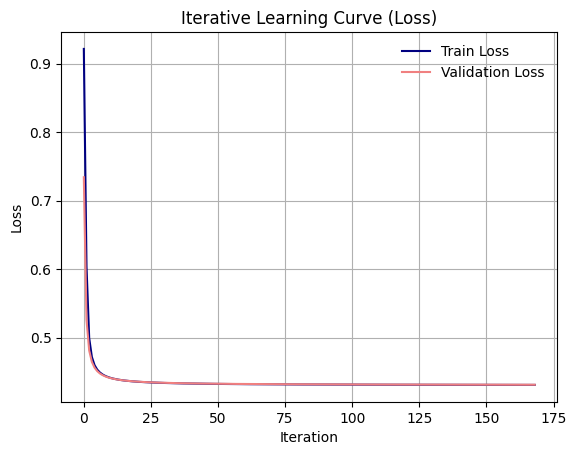

In [8]:
#10 Iterations
# plot the iterative learning curve (loss)
plt.plot(net.history[:, 'train_loss'], label='Train Loss', color='navy')
plt.plot(net.history[:, 'valid_loss'], label='Validation Loss', color='lightcoral')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Iterative Learning Curve (Loss)")
plt.grid(visible=True)
plt.legend(frameon=False)

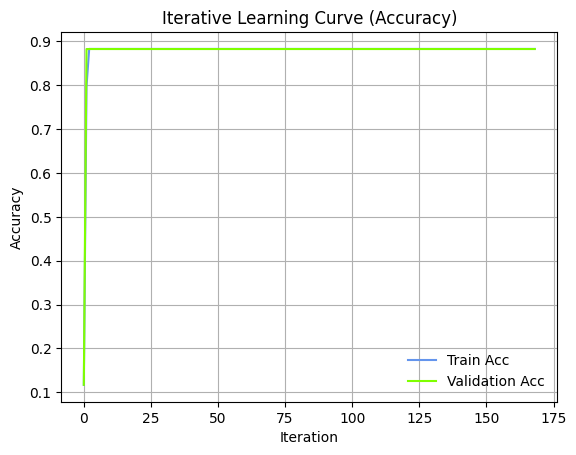

In [9]:
# plot the iterative learning curve (accuracy)
plt.plot(net.history[:, 'train_acc'], label='Train Acc', color='cornflowerblue')
plt.plot(net.history[:, 'valid_acc'], label='Validation Acc', color='chartreuse')
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Iterative Learning Curve (Accuracy)")
plt.grid(visible=True)
plt.legend(frameon=False)


## Using sklearn learning curve with RO

In [42]:
from sklearn.model_selection import learning_curve

# Plot the learning curve
train_sizes, train_scores, test_scores = learning_curve(
    net, X1.values.astype(np.float32), Y1.values.ravel().astype(np.int64), cv=3
)

train_scores_mean = train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
test_scores_mean = test_scores.mean(axis=1)
test_scores_std = test_scores.std(axis=1)
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color='cyan')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color='darkorchid')
plt.plot(train_sizes, train_scores_mean, label="Training score", color='cyan')
plt.plot(train_sizes, test_scores_mean, label="Test score", color='darkorchid')
plt.title("Learning Curve")
plt.xlabel("Training size")
plt.ylabel("Score")
plt.grid(visible=True)
plt.legend(frameon=False)

  epoch    train_acc    train_loss    valid_acc    valid_loss     dur
-------  -----------  ------------  -----------  ------------  ------
      1       0.8833        0.6389       0.9000        0.6322  0.0030
      2       0.8833        0.6335       0.9000        0.6291  0.0029
      3       0.8833        0.6288       0.9000        0.6260  0.0029
      4       0.8833        0.6321       0.9000        0.6229  0.0030
      5       0.8833        0.6292       0.9000        0.6199  0.0030
      6       0.8833        0.6226       0.9000        0.6170  0.0027
      7       0.8833        0.6174       0.9000        0.6141  0.0043
      8       0.8833        0.6176       0.9000        0.6112  0.0028
      9       0.8833        0.6149       0.9000        0.6084  0.0066
     10       0.8833        0.6139       0.9000        0.6057  0.0026
     11       0.8833        0.6103       0.9000        0.6030  0.0026
     12       0.8833        0.6128       0.9000        0.6004  0.0031
     13       0.8833

     35       0.8833        0.5607       0.9000        0.5522  0.0037
     36       0.8833        0.5563       0.9000        0.5505  0.0062
     37       0.8833        0.5592       0.9000        0.5489  0.0029
     38       0.8833        0.5557       0.9000        0.5473  0.0032
     39       0.8833        0.5553       0.9000        0.5458  0.0027
     40       0.8833        0.5532       0.9000        0.5442  0.0029
     41       0.8833        0.5530       0.9000        0.5427  0.0027
     42       0.8833        0.5487       0.9000        0.5413  0.0027
     43       0.8833        0.5505       0.9000        0.5398  0.0030
     44       0.8833        0.5519       0.9000        0.5384  0.0024
     45       0.8833        0.5472       0.9000        0.5370  0.0027
     46       0.8833        0.5465       0.9000        0.5356  0.0030
     47       0.8833        0.5410       0.9000        0.5343  0.0026
     48       0.8833        0.5469       0.9000        0.5330  0.0028
     49       0.8833

## Using sklearn pipeline

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipe = Pipeline([
    ('scale', StandardScaler()),
    ('net', net),
])

pipe.fit(X1.values.astype(np.float32), Y1.values.ravel().astype(np.int64))
y_proba = pipe.predict_proba(X1.values.astype(np.float32))

Re-initializing module because the following parameters were re-set: activation, dropout_percent, hidden_layers, hidden_units, input_dim, output_dim.
Re-initializing criterion because the following parameters were re-set: weight.
Re-initializing optimizer.
  epoch    train_acc    train_loss    valid_acc    valid_loss     dur
-------  -----------  ------------  -----------  ------------  ------
      1       0.2568        0.6914       0.2641        0.6909  0.0527
      2       0.3102        0.6906       0.3061        0.6902  0.0524
      3       0.3625        0.6898       0.3304        0.6895  0.0518
      4       0.3743        0.6891       0.3624        0.6887  0.0527
      5       0.4086        0.6880       0.3757        0.6879  0.0511
      6       0.4233        0.6870       0.4265        0.6867  0.0524
      7       0.4612        0.6857       0.4376        0.6856  0.0569
      8       0.4811        0.6842       0.4475        0.6842  0.0514
      9       0.4871        0.6824       0.

## Using sklearn grid search

In [ ]:
from sklearn.model_selection import GridSearchCV

# deactivate skorch-internal train-valid split and verbose logging
net.set_params(train_split=False, verbose=0)

default_params = {
    'module__input_dim': [12],
    'module__output_dim': [2],
}

# module specific parameters need to begin with 'module__'
params = {
    'lr': [0.01, 0.02],
    'max_epochs': [10, 20],
    'module__hidden_units': [10, 20],
    **default_params,
}
gs = GridSearchCV(net, params, refit=False, cv=3, scoring='accuracy', verbose=2)

gs.fit(X, y)
print("best score: {:.3f}, best params: {}".format(gs.best_score_, gs.best_params_))

NameError: name 'X' is not defined

In [10]:


# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X1, Y1, test_size=0.1, random_state=21)

hidden_units_list = [1,5,10, 15]  # Different widths to test
train_accuracies = []
valid_accuracies = []
valid_aucs = []

for hidden_units in hidden_units_list:
    net = NeuralNetClassifier(
        module=BackpropModule,
        module__input_dim=X1.shape[1],
        module__output_dim=2,  # Assuming target is categorical
        module__hidden_units=hidden_units,
        module__hidden_layers=1,  # Fixed number of hidden layers
        max_epochs=20,  # Number of epochs for training
        verbose=0,  # Suppress verbose output for clarity
        callbacks=[
            EpochScoring(scoring='accuracy', name='train_acc', on_train=True),
            #EpochScoring(scoring='accuracy', name='valid_acc', lower_is_better=False),
            #EpochScoring(scoring='roc_auc', name='valid_auc', lower_is_better=False),
        ],
        criterion=nn.CrossEntropyLoss,
        optimizer=torch.optim.SGD,
        lr=0.5,
        iterator_train__shuffle=True,
    )

    net.fit(X1.values.astype(np.float32), Y1.values.ravel().astype(np.int64))

    train_acc = net.history[-1, 'train_acc']
    valid_acc = net.history[-1, 'valid_acc']
    train_accuracies.append(train_acc)
    valid_accuracies.append(valid_acc)
    print(f'Hidden units: {hidden_units}, Train Acc: {train_acc},Valid Acc: {valid_acc} ')

    

Hidden units: 1, Train Acc: 0.8830522532485485,Valid Acc: 0.8827865831183193 
Hidden units: 5, Train Acc: 0.8830522532485485,Valid Acc: 0.8827865831183193 
Hidden units: 10, Train Acc: 0.8830522532485485,Valid Acc: 0.8827865831183193 
Hidden units: 15, Train Acc: 0.8830522532485485,Valid Acc: 0.8827865831183193 


: 

In [ ]:
net.history

[{'batches': [{'train_loss': 0.9882130026817322, 'train_batch_size': 128},
   {'train_loss': 0.49303191900253296, 'train_batch_size': 128},
   {'train_loss': 0.39758503437042236, 'train_batch_size': 128},
   {'train_loss': 0.41578659415245056, 'train_batch_size': 128},
   {'train_loss': 0.44001591205596924, 'train_batch_size': 128},
   {'train_loss': 0.4707050919532776, 'train_batch_size': 128},
   {'train_loss': 0.4660722613334656, 'train_batch_size': 128},
   {'train_loss': 0.4699136018753052, 'train_batch_size': 128},
   {'train_loss': 0.42321330308914185, 'train_batch_size': 128},
   {'train_loss': 0.4577793478965759, 'train_batch_size': 128},
   {'train_loss': 0.42786705493927, 'train_batch_size': 128},
   {'train_loss': 0.43149587512016296, 'train_batch_size': 128},
   {'train_loss': 0.4028521776199341, 'train_batch_size': 128},
   {'train_loss': 0.42452019453048706, 'train_batch_size': 128},
   {'train_loss': 0.5006234049797058, 'train_batch_size': 16},
   {'valid_loss': 0.47411

In [ ]:
train_acc = net.history[-1, 'train_acc']
    valid_acc = net.history[-1, 'valid_acc']
    valid_auc = net.history[-1, 'valid_auc']
    
    train_accuracies.append(train_acc)
    valid_accuracies.append(valid_acc)
    valid_aucs.append(valid_auc)

    print(f'Hidden units: {hidden_units}, Train Acc: {train_acc}, Valid Acc: {valid_acc}, Valid AUC: {valid_auc}')

net.history

[{'batches': [{'train_loss': 0.8532590866088867, 'train_batch_size': 128},
   {'train_loss': 276.5985412597656, 'train_batch_size': 128},
   {'train_loss': 171.8120880126953, 'train_batch_size': 128},
   {'train_loss': 267.4521789550781, 'train_batch_size': 128},
   {'train_loss': 1190.329833984375, 'train_batch_size': 128},
   {'train_loss': 826.4951171875, 'train_batch_size': 128},
   {'train_loss': 520.3899536132812, 'train_batch_size': 128},
   {'train_loss': 495203.8125, 'train_batch_size': 128},
   {'train_loss': 4300234.0, 'train_batch_size': 128},
   {'train_loss': 1.3066996690190336e+16, 'train_batch_size': 128},
   {'train_loss': 2897407639552.0, 'train_batch_size': 128},
   {'train_loss': nan, 'train_batch_size': 128},
   {'train_loss': nan, 'train_batch_size': 128},
   {'train_loss': nan, 'train_batch_size': 128},
   {'train_loss': nan, 'train_batch_size': 16},
   {'valid_loss': nan, 'valid_batch_size': 128},
   {'valid_loss': nan, 'valid_batch_size': 128},
   {'valid_loss'

In [ ]:
train_acc = net.history[-1, 'train_acc']
    valid_acc = net.history[-1, 'valid_acc']
    #valid_auc = net.history[-1, 'valid_auc']
    
    train_accuracies.append(train_acc)
    #valid_accuracies.append(valid_acc)
    #valid_aucs.append(valid_auc)

    #print(f'Hidden units: {hidden_units}, Train Acc: {train_acc}, Valid Acc: {valid_acc}, Valid AUC: {valid_auc}')

plt.figure(figsize=(12, 6))
plt.plot(hidden_units_list, train_accuracies, label='Train Accuracy')
#plt.plot(hidden_units_list, valid_accuracies, label='Validation Accuracy')
#plt.plot(hidden_units_list, valid_aucs, label='Validation AUC')
plt.xlabel('Number of Hidden Units')
plt.ylabel('Score')
plt.title('Validation Curve for Different Neural Net Widths')
plt.legend()
plt.grid(True)
plt.show()